In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statistics import mean
from datetime import date
import file

In [2]:
# Define the ticker symbol
tickerSymbol = 'MAGX'

# Get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
history = tickerData.history(interval='1wk', start='2022-1-1', end=date.today())

In [3]:
display(history)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2024-02-26 00:00:00-05:00,25.549999,26.440001,25.110001,26.356001,39200,0.0,0.0,0.0
2024-03-04 00:00:00-05:00,26.370001,27.410000,24.650000,25.634001,28500,0.0,0.0,0.0
2024-03-11 00:00:00-04:00,25.340000,26.357000,25.000000,25.290001,11700,0.0,0.0,0.0
2024-03-18 00:00:00-04:00,26.615000,27.730000,25.400000,27.488001,114300,0.0,0.0,0.0
2024-03-25 00:00:00-04:00,27.138000,27.840000,26.350000,26.490000,40700,0.0,0.0,0.0
2024-04-01 00:00:00-04:00,26.459999,27.360001,25.709999,26.700001,36100,0.0,0.0,0.0
2024-04-08 00:00:00-04:00,27.049999,28.150000,26.320000,27.260000,45300,0.0,0.0,0.0
2024-04-15 00:00:00-04:00,27.010000,27.190001,22.910000,23.129999,73600,0.0,0.0,0.0
2024-04-22 00:00:00-04:00,23.260000,25.820000,22.580999,25.730000,38300,0.0,0.0,0.0


In [4]:
max_weeks = min(52, len(history)-1)

In [5]:

gap = (1/40)*100

option_prices = {
    4: [34/1.6],
    5: [33/1.92],
    8: [34/2.3],
    9: [33/2.6],
    17: [34/3.6],
    18: [33/3.97],
    30: [34/4.65],
    31: [33/4.97],
}
print('option leverages:')
for w in sorted(option_prices.keys()):
    print(f'\t{w:2}w', *[f'{x:4.1f}' for x in option_prices[w]])

option_leverage = {w:mean(option_prices[w]) for w in option_prices}
print('mean option leverage, break even:')
for w in sorted(option_leverage.keys()):
    print(f'\t{w:2}w {option_leverage[w]:4.1f} {gap + 100/option_leverage[w]:4.1f}%')
print(f'option gap: {gap:.2f}%')

file.save_option_leverage(tickerSymbol, option_leverage)


option leverages:
	 4w 21.2
	 5w 17.2
	 8w 14.8
	 9w 12.7
	17w  9.4
	18w  8.3
	30w  7.3
	31w  6.6
mean option leverage, break even:
	 4w 21.2  7.2%
	 5w 17.2  8.3%
	 8w 14.8  9.3%
	 9w 12.7 10.4%
	17w  9.4 13.1%
	18w  8.3 14.5%
	30w  7.3 16.2%
	31w  6.6 17.6%
option gap: 2.50%


In [6]:
stock_change = [None]
option_performance = []
for weeks in range(1, max_weeks+1):
    stock_changes = history['Close'].pct_change(periods=weeks) * 100
    stock_change.append(stock_changes.median())
    window_max = history['High'].rolling(window=pd.api.indexers.FixedForwardWindowIndexer(window_size=weeks)).max()

    if weeks in option_leverage:
        lvr = option_leverage[weeks]
        option_profits = ((stock_changes[weeks:] - gap) * lvr - 100).clip(lower=-100)
        mean_profit = option_profits.mean() #* 52 / weeks # annualized
        positive_percent = (option_profits > 0).mean() * 100
        wmax = (((window_max / history['Open'] - 1) * 100 - gap) * lvr - 100).clip(lower=-100).median() - 100
        option_performance.append([weeks, mean_profit, positive_percent, wmax])
        history[f'Option {weeks}w'] = option_profits # * 52 / weeks # annualized

In [7]:
print('Option performance (weeks, profit, positive, w max):')
for p in option_performance:
    weeks = p[0]
    print(f'\t{weeks:2}w {p[1]:4.0f}% {p[2]:3.0f}% {p[3]:4.0f}%')

Option performance (weeks, profit, positive, w max):
	 4w   37%  45%  -43%
	 5w   32%  38%  -18%
	 8w   90%  50%  133%
	 9w   82%  47%   98%
	17w  170%  78%  308%
	18w  134%  75%  238%


In [8]:
from file import save_file

save_file(tickerSymbol, option_performance)

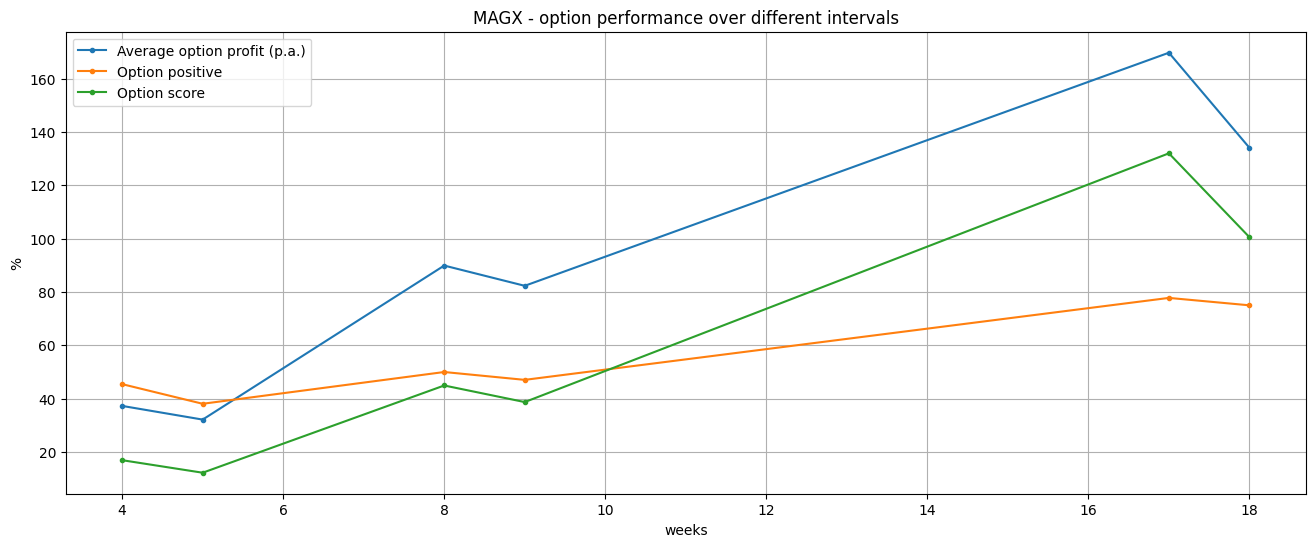

In [9]:
plt.figure(figsize=(16,6))
option_weeks = [p[0] for p in option_performance]
option_profit = [p[1] for p in option_performance]
option_positive = [p[2] for p in option_performance]
option_score = [x * y / 100 for x, y in zip(option_profit, option_positive)]
plt.plot(option_weeks, option_profit, label='Average option profit (p.a.)', marker='.')
plt.plot(option_weeks, option_positive, label='Option positive', marker='.')
plt.plot(option_weeks, option_score, label='Option score', marker='.')
plt.legend(loc='best')
plt.title(f'{tickerSymbol} - option performance over different intervals')
plt.xlabel('weeks')
plt.ylabel('%')
plt.grid()
plt.show()

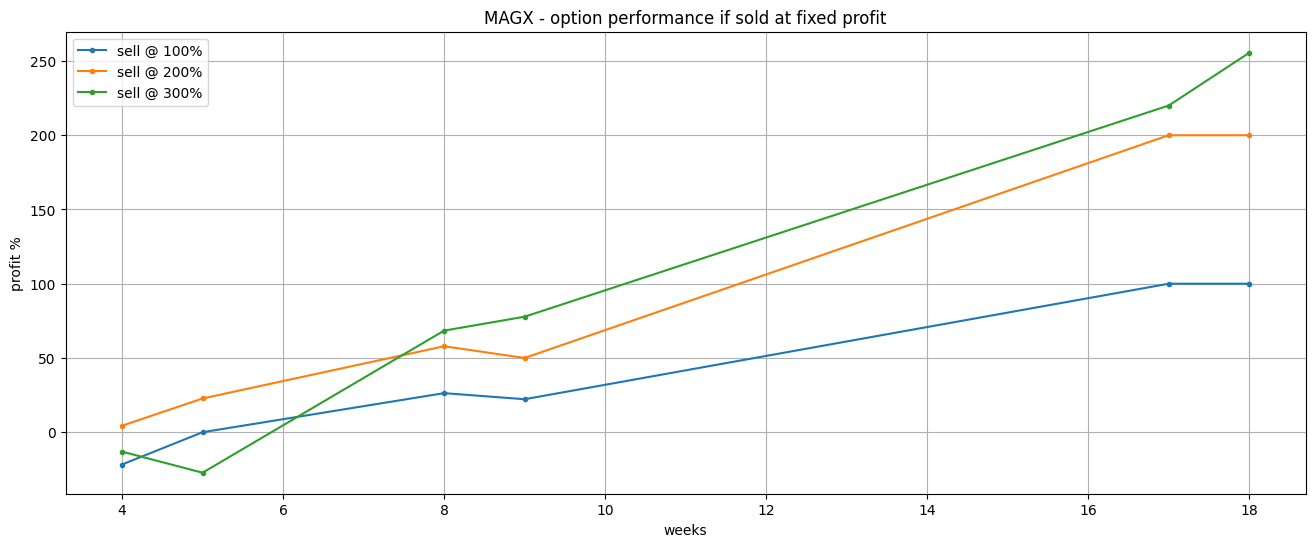

In [10]:
plt.figure(figsize=(16,6))

for percent in [100,200,300]:
    data = {}
    for weeks in option_leverage:
        lvr = option_leverage[weeks]
        window_max = history['High'].rolling(window=pd.api.indexers.FixedForwardWindowIndexer(window_size=weeks)).max()
        wmax = (((window_max / history['Open'] - 1) * 100 - gap) * lvr - 100).clip(lower=-100)
        wmax = wmax.dropna()
        q = (wmax >= percent).mean()
        # print(f'{weeks}w q:{q:.2f} wmax:', wmax.describe())
        # display(wmax)
        data[weeks] = q * (percent + 100) - 100

    # display(data)
    plt.plot(*zip(*sorted(data.items())), label=f'sell @ {percent}%', marker='.')

plt.legend(loc='best')
plt.title(f'{tickerSymbol} - option performance if sold at fixed profit')
plt.xlabel('weeks')
plt.ylabel('profit %')
plt.grid()
plt.show()

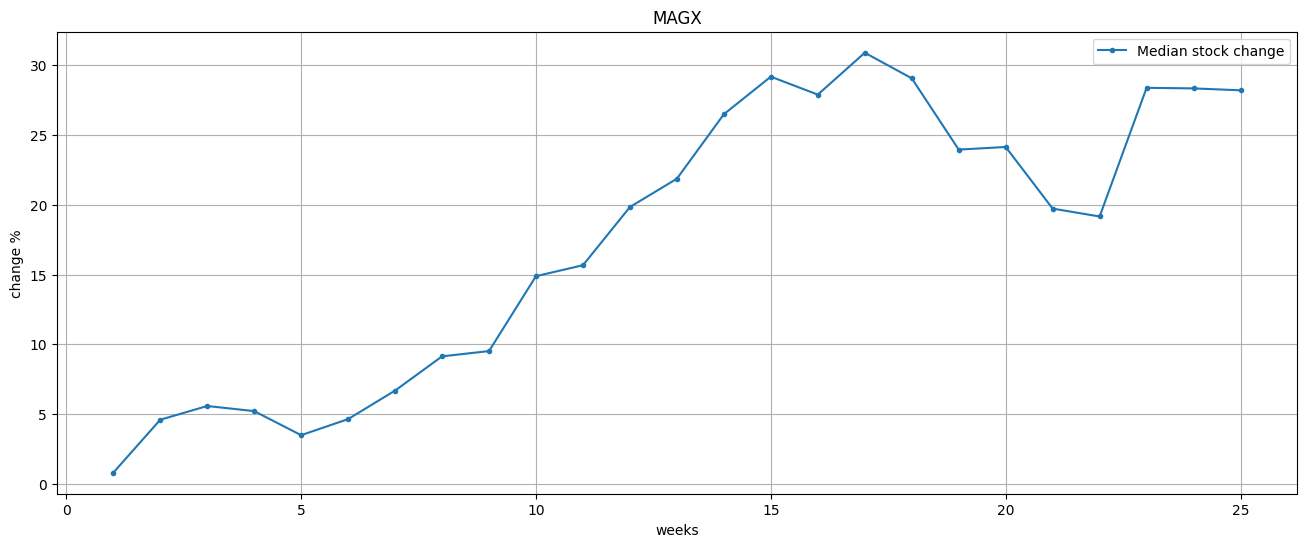

In [11]:
plt.figure(figsize=(16,6))
plt.plot(stock_change, label='Median stock change', marker='.')
plt.legend(loc='best')
plt.title(tickerSymbol)
plt.xlabel('weeks')
plt.ylabel('change %')
plt.grid()
plt.show()


KeyError: 'Option 31w'

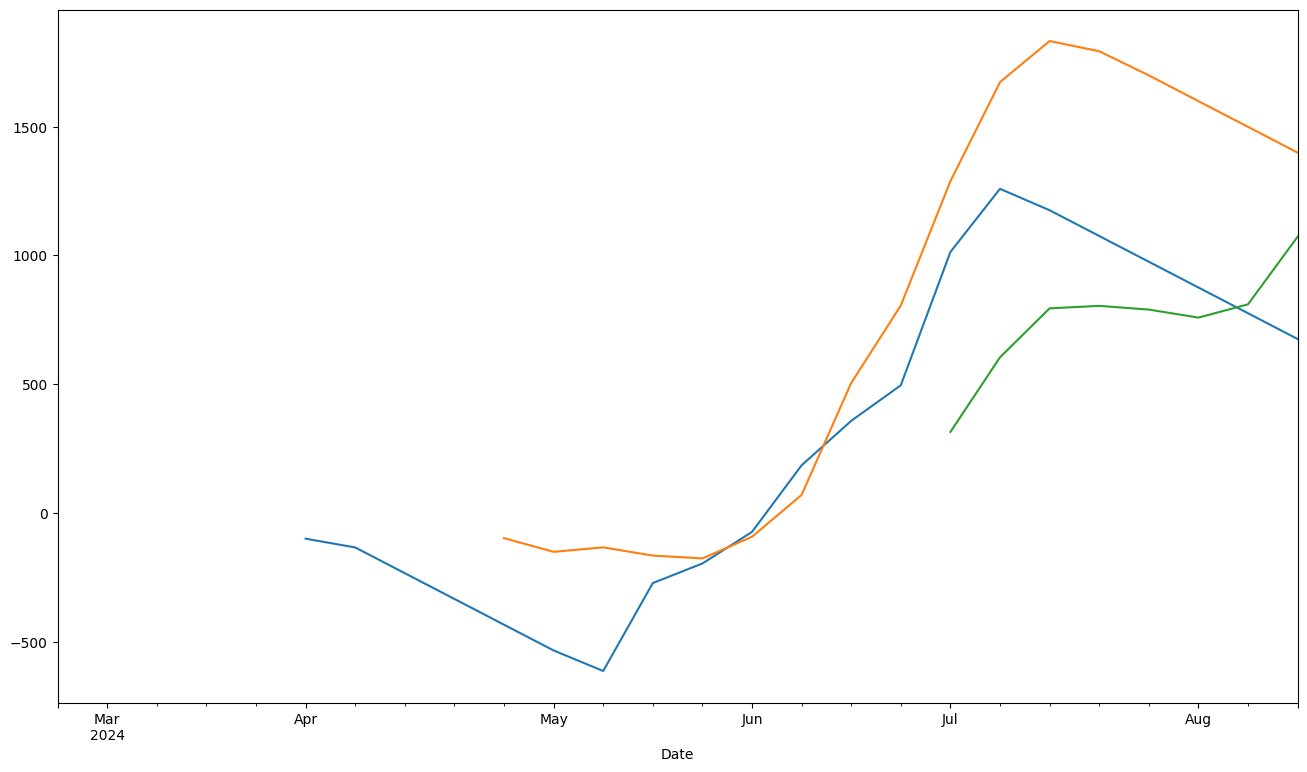

In [12]:
plt.figure(figsize=(16,9))

for w in [5,9,18,31]:
    history[f'Option {w}w'].cumsum().plot()

plt.legend()
plt.title(f'{tickerSymbol} - option performance')
plt.ylabel('%')
plt.grid()
plt.show()


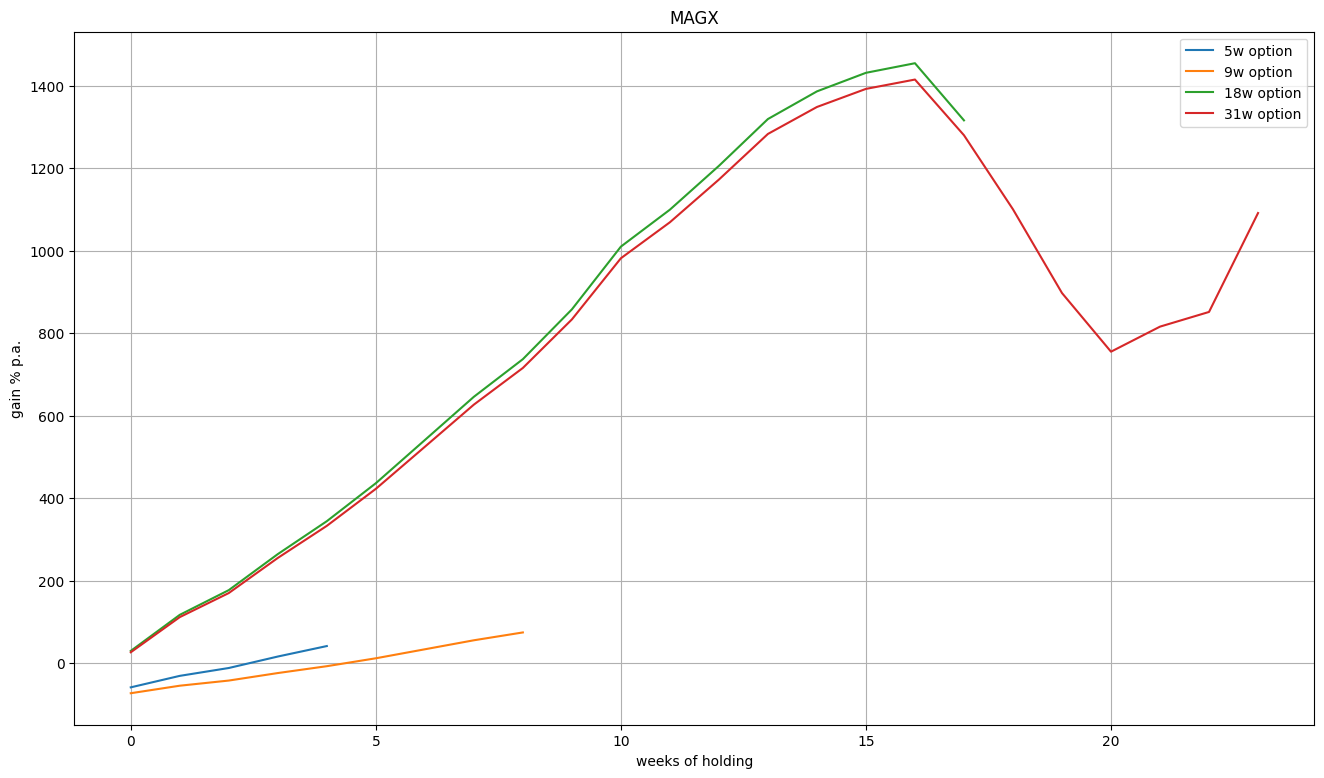

In [ ]:
plt.figure(figsize=(16,9))

for w in option_leverage:
    lvr = option_leverage[w]
    gains = []
    for weeks in range(1, w+1):
        stock_changes = history['Close'].pct_change(periods=weeks) * 100
        option_profits = ((stock_changes[weeks:] - gap) * lvr - 100).clip(lower=-100)
        mean_profit = option_profits.mean() #* 52 / weeks # annualized
        gains.append(mean_profit if mean_profit > -100 else None)
    plt.plot(gains, label=f'{w}w option')
        
plt.legend(loc='upper right')
plt.title(tickerSymbol)
plt.xlabel('weeks of holding')
plt.ylabel('gain % p.a.')
plt.grid()
plt.show()